### Do it! 실습 | 종교 변수 검토 및 전처리하기

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns

In [54]:
# 데이터 불러오기
raw_welfare = pd.read_spss('/Users/heohyeonjun/Desktop/We_IT_5th/weit/Data/Koweps_hpwc14_2019_beta2.sav')

# 복사본 만들기
welfare = raw_welfare.copy()

In [55]:
welfare = welfare.rename(
    columns = {
        'h14_g3' : 'sex', # 성별
        'h14_g4' : 'birth', # 태어난 연도
        'h14_g10' : 'marriage_type', # 혼인 상태
        'h14_g11' : 'religion', # 종교
        'p1402_8aq1' : 'income', # 월급
        'h14_eco9' : 'code_job', # 직업 코드
        'h14_reg7' : 'code_region' # 지역 코드
    }
)

In [56]:
# 이상치 결측 처리
welfare['sex'] = np.where(welfare['sex'] == 9, np.nan, welfare['sex'])

# 결측치 확인
welfare['sex'].isna().sum()

0

In [57]:
# 성별 항목 이름 부여
welfare['sex'] = np.where(welfare['sex'] == 1, 'male', 'female')

# 빈도 구하기
welfare['sex'].value_counts()

female    7913
male      6505
Name: sex, dtype: int64

In [58]:
# 이상치 결측 처리
welfare['income'] = np.where(welfare['income'] == 9999, np.nan, welfare['income'])

# 결측치 확인
welfare['income'].isna().sum()

9884

In [59]:
welfare = welfare.assign(age = 2019 - welfare['birth'] + 1) # 나이 변수 만들기
welfare['age'].describe()

count    14418.000000
mean        50.719795
std         24.402250
min          2.000000
25%         30.000000
50%         52.000000
75%         72.000000
max        113.000000
Name: age, dtype: float64

In [60]:
# 연령대 변수 만들기
welfare = welfare.assign(ageg = np.where(welfare['age'] < 30, 'young',
                                np.where(welfare['age'] <= 59,'middle',
                                                                'old')))

# 빈도 구하기
welfare['ageg'].value_counts()

old       5955
middle    4963
young     3500
Name: ageg, dtype: int64

In [61]:
# 직업분류 코드 확인
list_job = pd.read_excel('/Users/heohyeonjun/Desktop/We_IT_5th/weit/Data/Koweps_Codebook_2019.xlsx', sheet_name='직종코드')
# welfare에 list_job 결합하기
welfare = welfare.merge(list_job, how='left', on='code_job')


### --------------------- 여기부터 ------------------------

In [62]:
welfare['religion'].dtypes

dtype('float64')

In [63]:
welfare['religion'].value_counts() # 빈도 구하기

2.0    7815
1.0    6603
Name: religion, dtype: int64

In [64]:
# 종교 유무 이름 부여
welfare['religion'] = np.where(welfare['religion'] == 1, 'yes', 'no')

# 빈도 구하기
welfare['religion'].value_counts()

no     7815
yes    6603
Name: religion, dtype: int64

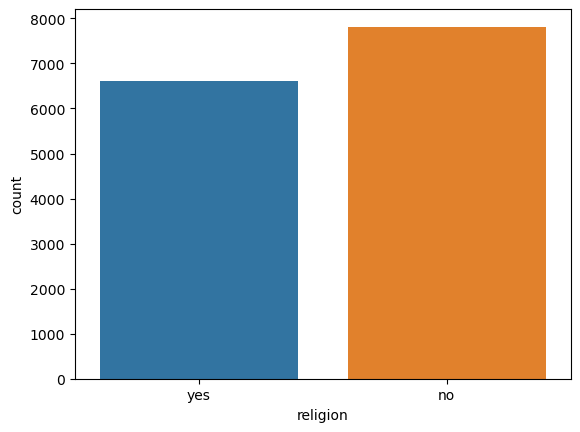

In [65]:
import matplotlib.pyplot as plt

# 막대 그래프 만들기
sns.countplot(data=welfare, x='religion', hue='religion')
plt.show()

### Do it! 실습 | 혼인 상태 변수 검토 및 전처리하기

In [66]:
welfare['marriage_type'].dtypes

dtype('float64')

In [67]:
welfare['marriage_type'].value_counts() # 빈도 구하기

1.0    7190
5.0    2357
0.0    2121
2.0    1954
3.0     689
4.0      78
6.0      29
Name: marriage_type, dtype: int64

In [68]:
# 이혼 여부 변수 만들기
welfare['marriage'] = np.where(welfare['marriage_type'] == 1, 'marriage',
                                np.where(welfare['marriage_type'] == 3, 'divorce',
                                                                        'etc'))

In [69]:
# 이혼 여부별 빈도
# 1. marriage별 분리
# 2. marriage별 빈도 구하기
n_divorce = welfare.groupby('marriage', as_index=False).agg(n = ('marriage', 'count'))
n_divorce

,marriage,n
0,divorce,689
1,etc,6539
2,marriage,7190


<AxesSubplot:xlabel='marriage', ylabel='n'>

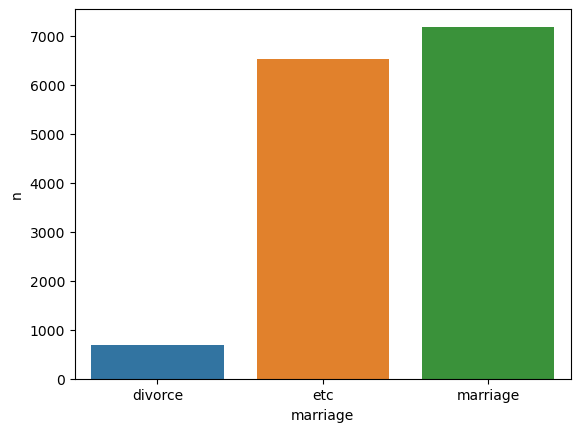

In [70]:
# 막대 그래프 만들기
sns.barplot(data=n_divorce, x='marriage', y='n', hue='marriage')

### Do it! 실습 | 종교 유무에 따른 이혼율 분석하기

In [71]:
# etc 제외
# religion 별 분리
# marriage 추출
# 비율 구하기
rel_div = welfare.query('marriage != "etc"').groupby('religion', as_index = False)['marriage'].value_counts(normalize=True)
rel_div

,religion,marriage,proportion
0,no,marriage,0.905045
1,no,divorce,0.094955
2,yes,marriage,0.920469
3,yes,divorce,0.079531


In [72]:
# divorce 추출
# 백분율로 바꾸기
# 반올림
rel_div = rel_div.query('marriage == "divorce"').assign(proportion = rel_div['proportion'] * 100).round(1)
rel_div

,religion,marriage,proportion
1,no,divorce,9.5
3,yes,divorce,8.0


<AxesSubplot:xlabel='religion', ylabel='proportion'>

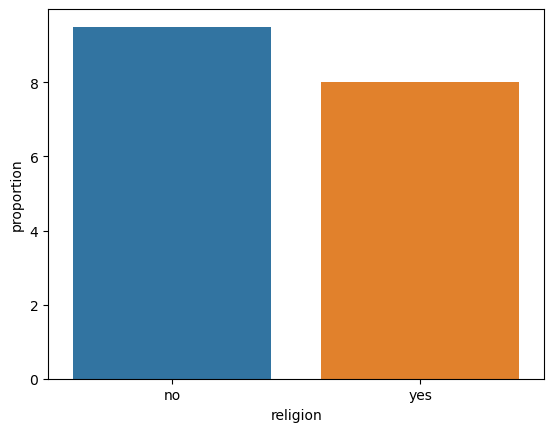

In [73]:
# 막대 그래프 만들기
sns.barplot(data=rel_div, x = 'religion', y= 'proportion', hue='religion')

### Do it! 실습 | 연령대 및 종교 유무에 따른 이혼율 분석하기

In [82]:
# 1. etc 제외
# 2. ageg별 분리
# 3. marriage 추출
# 4. 비율 구하기

age_div = welfare.query('marriage != "etc"').groupby('ageg', as_index = False)['marriage'].value_counts(normalize = True)
age_div

,ageg,marriage,proportion
0,middle,marriage,0.910302
1,middle,divorce,0.089698
2,old,marriage,0.914220
3,old,divorce,0.085780
4,young,marriage,0.950000
5,young,divorce,0.050000


In [83]:
# 초년 제외, 이혼 추출
# 백분율로 바꾸기
# 반올림
age_div = age_div.query('ageg != "young" & marriage == "divorce"').assign(proportion = age_div['proportion'] * 100).round(1)
age_div

,ageg,marriage,proportion
1,middle,divorce,9.0
3,old,divorce,8.6


<AxesSubplot:xlabel='ageg', ylabel='proportion'>

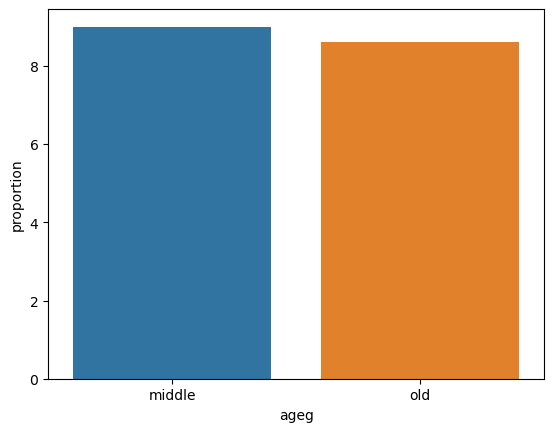

In [84]:
# 막대 그래프 만들기
sns.barplot(data=age_div, x='ageg', y='proportion', hue='ageg')

In [87]:
# etc 제외, 초년 제외
# ageg, religion별 분리
# marriage 추출
# 비율 구하기

age_rel_div = welfare.query('marriage != "etc" & ageg != "young"').groupby(['ageg', 'religion'], as_index=False)['marriage'].value_counts(normalize = True)
age_rel_div

,ageg,religion,marriage,proportion
0,middle,no,marriage,0.904953
1,middle,no,divorce,0.095047
2,middle,yes,marriage,0.917520
3,middle,yes,divorce,0.082480
4,old,no,marriage,0.904382
5,old,no,divorce,0.095618
6,old,yes,marriage,0.922222
7,old,yes,divorce,0.077778


In [89]:
# divorce 추출
# 백분율로 바꾸기
# 반올림

age_rel_div = age_rel_div.query('marriage == "divorce"').assign(proportion = age_rel_div['proportion'] * 100).round(1)
age_rel_div

,ageg,religion,marriage,proportion
1,middle,no,divorce,9.5
3,middle,yes,divorce,8.2
5,old,no,divorce,9.6
7,old,yes,divorce,7.8


<AxesSubplot:xlabel='ageg', ylabel='proportion'>

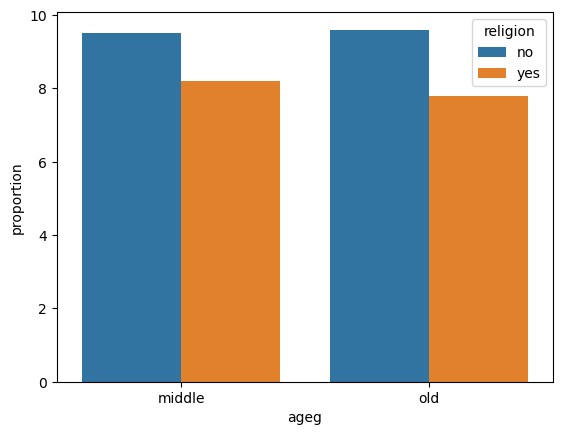

In [90]:
# 막대 그래프 만들기
sns.barplot(data=age_rel_div, x='ageg', y='proportion', hue='religion')